In [1]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, z_score_normalization
from project.utils import collate_fn, plot_mri_slice, plot_all_slices, plot_all_slices_from_array, collatev2
import winsound
from torchvision.models import resnet18, ResNet18_Weights
from project.utils import memcheck, compute_statistics

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.20 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
import logging
logger = logging.getLogger('andy')
fh = logging.FileHandler('andy.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 5)

In [4]:
data = pd.DataFrame({
    'mri': ds.load_raw_mri(),
    'masks': ds.load_cmb_masks(),
})

data['target'] = 0
data

,mri,masks,target
0,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,0
1,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,0
2,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,0
3,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,0
4,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,0
...,...,...,...
67,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,0
68,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,0
69,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,0
70,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,0


### Select a cohort

In [5]:
ch1 = ds.load_raw_mri(1)
ch2 = ds.load_raw_mri(2)
ch3 = ds.load_raw_mri(3)
data = data[data.mri.isin(ch3)]
data.shape

(27, 3)

### Train and Test Split

In [6]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(
    data,
    test_size=0.2,
    random_state=12
)

data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [7]:
data_train.shape, data_test.shape

((21, 3), (6, 3))

### Normalization

In [8]:
global_min, global_max = compute_statistics(data_train.mri.tolist())

In [9]:
global_min, global_max

(0.0, 664.0)

In [10]:
transform = NiftiToTensorTransform(
    target_shape = (300, 300),
    rpn_mode=True,
    normalization=(global_min, global_max)
) # Hanggang dito lang kaya ng GPU mem ko

### Dataloaders

In [11]:
train_set = VALDODataset(
    cases=data_train.mri.tolist(),
    masks=data_train.masks.tolist(),
    target=data_train.target.tolist(),
    transform=transform,
)

val_set = VALDODataset(
    cases=data_test.mri,
    masks=data_test.masks,
    target=data_test.target,
    transform=transform,
)

batch_size = 5

train_loader = DataLoader(
    train_set,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=collatev2,
)

val_loader = DataLoader(
    val_set,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=collatev2,
)

### Config for fitter

In [36]:
from project.model import SliceEmbedding, Autoencoder, Decoder

image_size = 300
input_output_dim = 2500

en = SliceEmbedding(
    image_size=image_size,
    output_dim=input_output_dim,
)

de = Decoder(
    image_size=image_size,
    input_dim=input_output_dim
)

config = {
    'model': Autoencoder(en, de).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 100,
    # 'loss': nn.MSELoss(),
    'loss': nn.L1Loss(),
    'lr': 0.0001
}

1369


### Sample trial

### Fitter

In [13]:
from project import Fitter

class AEFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        counter = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                if slices is None:
                    logger.error(f'CASE NOT WORKING: {case}')
                    continue
                x = slices.squeeze(1).float().to(self.device)
                y = self.model(x)
                # logger.info(f'MEMORY after X, Y, T to device\t{memcheck()}')
                losses = self.loss(y, x)
                self.optimizer.zero_grad()
                losses.backward()
                self.optimizer.step()
                loss_history.append(losses.detach().cpu().numpy())
            
            counter += len(batch)
            if counter % 100 == 0:
                # logger.info(f'Progress:\t{counter}/{len(dataset)}')
                self.log(f'Current error:\t{losses}')

            # del losses, Y, T
            # torch.cuda.empty_cache()
            # logger.info(f'MEMORY after CLEARING MEMORY\t{memcheck()}')
            
        return loss_history
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    x = slices.squeeze(1).float().to(self.device)
                    masks = masks.squeeze(1).float().to(self.device)/300
                    y = self.model(x)
                    losses = self.loss(y, x)
                    loss_history.append(losses.cpu().numpy())
        return loss_history

In [14]:
fitter = AEFitter(config, logger=logger)

### Training

In [15]:
thist, vhist = fitter.fit(train_loader, val_loader)

INFO:andy:EPOCH 0 ==============================
C:\Program Files\Python310\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Program Files\Python310\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
INFO:andy:EPOCH 1 ==============================
INFO:andy:EPOCH 2 ==============================
INFO:andy:EPOCH 3 ==============================
INFO:andy:EPOCH 4 ===========

In [16]:
winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

<Axes: >

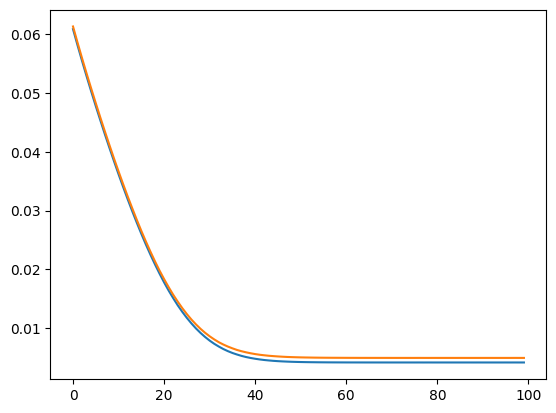

In [17]:
import seaborn as sns
import numpy as np

th = torch.tensor(np.array(thist))
vh = torch.tensor(np.array(vhist))
# print(th.shape)
sns.lineplot(th.mean(1))
sns.lineplot(vh.mean(1))

tensor(0.0121)

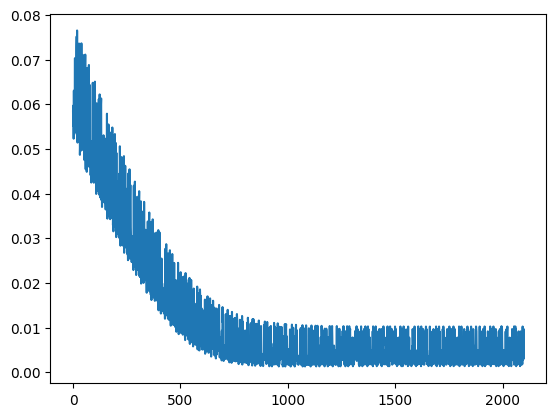

In [18]:
sns.lineplot(th.flatten())
th.flatten().mean()

# Summary

Applied train_test splits and normalization in training

### Save Encoder Weights

# Trial

In [19]:
model = fitter.model

In [20]:
sample = next(enumerate(train_loader))

In [21]:
slices, masks, target, case = sample[1][0]

In [22]:
masks[target]

tensor([[[0., 0., 0., 0.]]], dtype=torch.float64)

In [23]:
num_slices = slices.shape[0]
num_slices

39

In [24]:
x = slices.squeeze(1).float().to(device)
T = masks.squeeze(1).float().to(device)

In [25]:
y = model(x)

In [26]:
fitter.loss(y, x)

tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

In [27]:
y.shape

torch.Size([39, 1, 300, 300])

<Axes: >

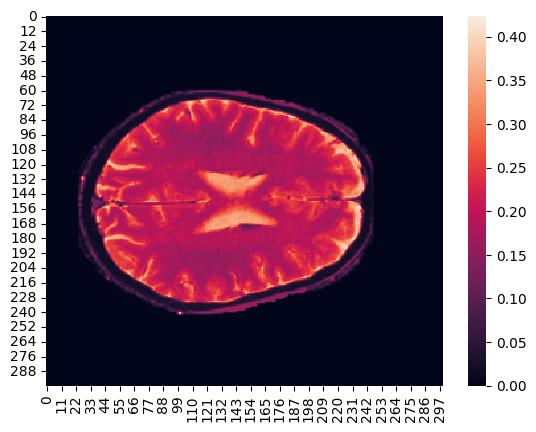

In [28]:
sns.heatmap(x[20].squeeze().cpu())

<Axes: >

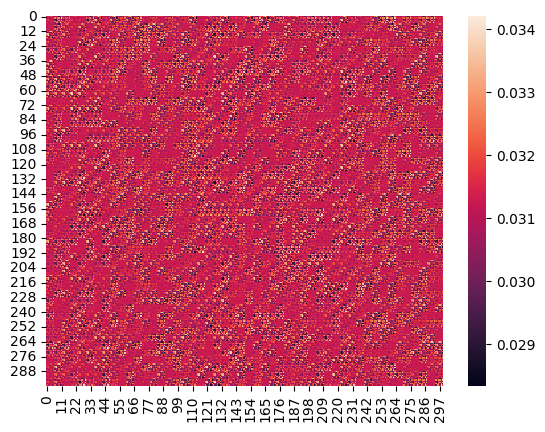

In [29]:
sns.heatmap(y[20].squeeze().detach().cpu())